# Определение токсичности комментариев

## Введение

Интернет-магазин «Викишоп» запускает пользовательский интерактивный сервис комментирования описаний товаров. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

В нашем распоряжении набор данных с разметкой о токсичности правок. 


**Цель проекта:** обучить модель классифицировать комментарии на позитивные и негативные, со значением метрики качества *F1* не меньше *0.75.*  


**Описание данных:**

 - Датасет: **`toxic_comments.csv`**. 
 - Текст комментария: столбец **`text`**.
 - Целевой признак: столбец **`toxic`**.
 
 
 **План выполнения проекта:**

1. Загрузить данные и подготовить для обучения, используя разные инструменты (TF-IDF, BERT).
2. Обучить разные модели. 
3. Сделать выводы.


## Загрузка и подготовка

In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import re
import nltk
import chardet  
from transformers import DistilBertTokenizer, DistilBertModel
from tqdm import tqdm
from imblearn.pipeline import Pipeline 
from wordcloud import WordCloud, ImageColorGenerator

from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords as nltk_stopwords
from nltk.corpus import wordnet as nltk_wordnet

from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.dummy import DummyClassifier

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

# настраиваем отображение
import warnings
warnings.filterwarnings('ignore')

# задаем переменные 
RAND_ST = 12345
BERT_SIZE = 2000
BATCH_SIZE = 100 
#nltk.download('stopwords')

- Перед загрузкой файла, с помощью библиотеки chardet проверим в нем кодировку текста.

In [2]:
# выясняем кодировку текста 
with open('/Volumes/Datasets/datasets/toxic_comments.csv', "r") as f:
    print(f)

<_io.TextIOWrapper name='/Volumes/Datasets/datasets/toxic_comments.csv' mode='r' encoding='UTF-8'>


- Кодировка в Юникоде. Можно выгружать файл, не прибегая к декодированию. 

In [3]:
# загружаем датаcет 

# сохраним датасет в переменную для обучения методом TF-IDF
df = pd.read_csv('/Volumes/Datasets/datasets/toxic_comments.csv', index_col=[0])

# сохраним датасет в переменную для обучения методом BERT
df_bert = pd.read_csv('/Volumes/Datasets/datasets/toxic_comments.csv', index_col=[0])

In [4]:
# изучаем данные
df.info()
df.sample(10)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 159292 entries, 0 to 159450
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159292 non-null  object
 1   toxic   159292 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.6+ MB


,text,toxic
16178,Reverting... \n\nYou might find it useful to p...,0
92669,Diagrams for knitting \n\nRe your request: I c...,0
82750,"Delicious carbuncle, please read my statementi...",0
81545,", 25 March 2013 (UTC)\n\nThat's some strange i...",0
124345,"Homey is, I am quite confident, far more aware...",0
125800,"""== Redirect for common spelling error==\nAdde...",0
131299,"""\n\n Game Guide \n\nThis is really starting t...",0
8609,I dont care about kurds actually (i am neutral...,1
93377,Just remove the signature and replace it with ...,0
90362,"""\n\n Administrator \n\nHey Jimbo can you make...",0


- Данные без пропусков. Язык комментариев - английский. Проверим баланс классов целевой переменной. 

In [5]:
# выводим уникальные значения целевого столбца
df.toxic.value_counts(normalize=True)

0    0.898388
1    0.101612
Name: toxic, dtype: float64

- Налицо явный дисбаланс в пользу нетоксичных комментариев. Учтем это при обучении моделей.

### Подготовка данных с TF-IDF

- Очистим и лемматизируем текст.

In [6]:
%%time
# cоздаем класс для лемматизации
lemmatizer = WordNetLemmatizer()

# создаем функцию лемматизации и очистки текста
def lemmatize_text(text):    
    text = text.lower()
    cleared_text = re.sub(r'[^a-zA-Z]', ' ', text) 
    lemm_text = "".join(lemmatizer.lemmatize(cleared_text))                     
    
    return " ".join(lemm_text.split())
        
# запускаем функцию, создавая новый столбец с очищенным текстом
df['lemm_text'] = df['text'].apply(lemmatize_text)

# удаляем лищний столбец
df = df.drop(['text'], axis=1)

# удаляем лишнюю переменную 
del lemmatizer

CPU times: user 9.97 s, sys: 117 ms, total: 10.1 s
Wall time: 10.1 s


- Проверим наличие дубликатов и удалим их.

In [7]:
# выводим количество дубликатов
df.duplicated().sum()

1294

In [8]:
# удаляем дубликаты
df.drop_duplicates(inplace=True, ignore_index=True)

In [9]:
# проверяем результат преобразований 
df.info()
df.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 157998 entries, 0 to 157997
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   toxic      157998 non-null  int64 
 1   lemm_text  157998 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


,toxic,lemm_text
67007,0,probably they weren t watching wwe at all all ...
83816,0,the subject of the email you sent was please c...
133499,0,redirect talk napier shootings
110773,0,urgent complain wikipedia answer given by you ...
156766,0,vandalism i am sorry
70237,0,blocked tagged cheers xman
141717,0,no done i removed this for a moment on more ca...
120432,1,it s not that you didn t manage the proper pro...
57898,0,okay i ll delete the mini game objectives and ...
26587,0,yeah there might be a chance but unless you pr...


#### Облако слов

- Воспользуемся библиотекой wordcloud и построим облако слов, чтобы получить представление о наиболее часто встречающиеся в комментариях словах. 

In [10]:
# выбираем вид комментария 
normal_words = df[df.toxic==0]
toxic_words = df[df.toxic==1]

In [11]:
# формируем списки всех, нетоксичных и токсичных комментариев
all_words = " ".join(review for review in df.lemm_text)
normal_words = " ".join(review for review in normal_words.lemm_text)
toxic_words = " ".join(review for review in toxic_words.lemm_text)

In [12]:
# создаем объекты для отображения на графиках
wordcloud_all = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(all_words)
wordcloud_normal = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(normal_words)
wordcloud_toxic = WordCloud(max_font_size=50, max_words=100, background_color="black").generate(toxic_words)

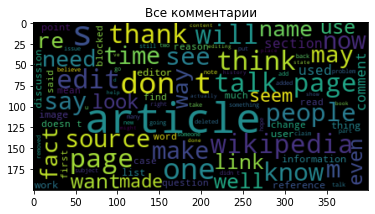

In [13]:
# выводим облако всех комментариев
plt.title('Все комментарии')
plt.imshow(wordcloud_all, interpolation='bilinear');

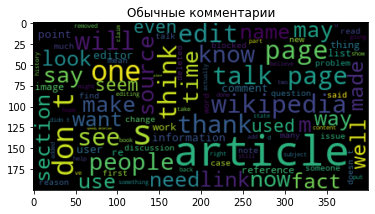

In [14]:
# выводим облако нетоксичных комментариев
plt.title('Обычные комментарии')
plt.imshow(wordcloud_normal, interpolation='bilinear');

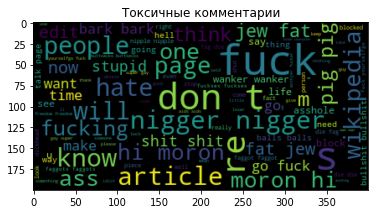

In [15]:
# выводим облако токсичных комментариев
plt.title('Токсичные комментарии')
plt.imshow(wordcloud_toxic, interpolation='bilinear');

- Иллюстрации наиболее часто употребляемых слов лишний раз  наглядно демонстрируют что, чем токсичнее, злее  комментарий, тем больше  в нем слов негативной коннотации, и напротив - чем нейтральнее твит, тем более взвешенные и позитивные слова в нем используются. 

- Разделим датасет на тестовую, валидационную и обучающую выборки и векторизуем признаки методом TF_IDF.

In [16]:
# разделяем данные на обучающую, валидационую и тестовую выборки (60/20/20)
target = df['toxic']
features = df['lemm_text']

train_features, test_features, train_target, test_target = train_test_split(features, target, 
                                                                random_state=RAND_ST, test_size=0.4)

valid_features, test_features, valid_target, test_target = train_test_split(test_features, test_target, 
                                                                     random_state=RAND_ST, test_size=0.5)


In [17]:
# проводим векторизацию признаков

# создаем корпус слов
corpus_train = train_features.values
corpus_valid = valid_features.values
corpus_test = test_features.values

# создаем список стоп-слов
stopwords = list(nltk_stopwords.words('english'))

# создаем матрицу cо значениями TF_IDF без стоп-слов
count_ft_idf = TfidfVectorizer(stop_words=stopwords)

# получаем tf_idf  матрицу признаков 
train_features_tf_idf = count_ft_idf.fit_transform(corpus_train)
valid_features_tf_idf = count_ft_idf.transform(corpus_valid)
test_features_tf_idf = count_ft_idf.transform(corpus_test)

# проверяем итоговый размер выборок
print(train_features_tf_idf.shape)
print(valid_features_tf_idf.shape) 
print(test_features_tf_idf.shape) 
print(train_target.shape) 
print(valid_target.shape) 
print(test_target.shape)

(94798, 125139)
(31600, 125139)
(31600, 125139)
(94798,)
(31600,)
(31600,)


### Подготовка данных с BERT

- Для работы используем предобученную модель DistilBERT. Она быстрее и легче базовой версии, но со сравнимой результативностью.

- Эмбеддинги с BERT могут создаваться долго. Чтобы немного ускорить процесс, возьмем выборку из 2000 сэмплов. 

In [18]:
# создаем выборку для эмбеддинга 
df_bert = df_bert.sample(BERT_SIZE + 500, random_state = RAND_ST).reset_index(drop = True) 
# проверяем
df_bert.info()
df_bert.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2500 non-null   object
 1   toxic   2500 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 39.2+ KB


,text,toxic
0,Expert Categorizers \n\nWhy is there no menti...,0
1,"""\n\n Noise \n\nfart* talk. """,1
2,"An indefinite block is appropriate, even for a...",0
3,I don't understand why we have a screenshot of...,0
4,"Hello! Some of the people, places or things yo...",0


In [19]:
# загружаем токенизатор и модель DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model = DistilBertModel.from_pretrained('distilbert-base-uncased')

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


- Токенизируем каждый твит.

In [20]:
# токенизируем каждый твит
tokenized = df_bert['text'].apply(
    lambda x: tokenizer.encode(x, add_special_tokens=True))

# ищем максимальную длину веторов 
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

print(max_len)  

Token indices sequence length is longer than the specified maximum sequence length for this model (526 > 512). Running this sequence through the model will result in indexing errors


1876


- BERT по умолчанию принимает токены с максимальной длиной 512. Оставим в выборке только векторы подходящей длины. 

In [21]:
# ограничиваем длину векторов
tokens = []
target = []
for i in range(len(tokenized)):
    if len(tokenized[i]) <= 512:
        tokens.append(tokenized[i])
        target.append(df_bert['toxic'][i])
tokens = (pd.Series(tokens)).head(BERT_SIZE)
target = (pd.Series(target)).head(BERT_SIZE)

- Уравняем длину векторов методом padding  и создадим маску для важных токенов.

In [22]:
# ищем максимальную длину веторов 
max_len = 0
for i in tokens.values:
    if len(i) > max_len:
        max_len = len(i)

# уравниваем длину викторов методом  padding       
padded = np.array([i + [0]*(max_len-len(i)) for i in tokens.values])

# создаем маску для важных токенов 
attention_mask = np.where(padded != 0, 1, 0)

# проверяем
display(padded.shape, attention_mask.shape)

(2000, 512)

(2000, 512)

- Создим эмбеддинги, испльзуя батчи размером 100.

In [23]:
# создаем эмбеддинги 
batch_size = BATCH_SIZE
embeddings = []
for i in tqdm(range(padded.shape[0] // batch_size)):
        batch = torch.LongTensor(padded[batch_size*i:batch_size*(i+1)]) 
        attention_mask_batch = torch.LongTensor(
                         attention_mask[batch_size*i:batch_size*(i+1)])
        
        with torch.no_grad():
            batch_embeddings = model(batch, attention_mask=attention_mask_batch)
        
        embeddings.append(batch_embeddings[0][:,0,:].numpy())

        features_bert = np.concatenate(embeddings)  

100%|███████████████████████████████████████████| 20/20 [29:58<00:00, 89.90s/it]


- Признаки получены.

- Разделим датасет на обучающую и тестовую выборки, зададим цель и признаки.

In [24]:
# формируем выборки, признаки и цель
target_bert = target.head(len(features_bert))
train_features_bert, test_features_bert, train_target_bert, test_target_bert = train_test_split(
                                features_bert, target_bert, test_size=0.4, random_state=RAND_ST)

valid_features_bert, test_features_bert, valid_target_bert, test_target_bert = train_test_split(
                       test_features_bert, test_target_bert, test_size=0.5, random_state=RAND_ST)

# проверяем
print(train_features_bert.shape)
print(valid_features_bert.shape)
print(test_features_bert.shape) 
print(train_target_bert.shape) 
print(valid_target_bert.shape) 
print(test_target_bert.shape)

(1200, 768)
(400, 768)
(400, 768)
(1200,)
(400,)
(400,)


### Вывод

- Загрузили датасет, проверили кодировку. 

- Создали две группы данных для обработки разными методами.

- В одной группе лемматизировали и очистили текст комментариев, удалили образовавшиеся дубликаты и векторизовали признаки методом TF_IDF.

- Сформировали "Облако слов": посмотрели частотность употребляемых в твитах слов.

- Активировали модель DistilBERT и с ее помощью обработали данные и создали вторую группу признаков.

- Разбили обе группы данных на обучающую, валидационную и тестовую выборки из расчета 60/20/20, подготовив их к обучению моделей.

- Подготовка данных с BERT занимает в десять раз больше времени, чем с TF-IDF.

## Обучение 

### Обучение с TF-IDF

- Проведем обучение моделей.

- Для работы выберем три модели:
   - LogisticRegression.
   - RandomForestClassificier.
   - CatBoostClassificier.


- Подберем гиперпараметры и оценим работу моделей кросс-валидацией.

In [25]:
# создаем функцию работы кросс-валидатора
def cv_score(estimator, parametrs, features, target):
    
    # задаем параметры пайплайна
    pipeline = Pipeline([ ('clf', estimator) ])

    # активируем поиск и запускаем обучение
    model_cv = HalvingRandomSearchCV(pipeline,
                                     param_distributions=parametrs,
                                     cv=8,
                                     n_jobs=-1,
                                     factor=2,
                                     max_resources=80,
                                     scoring='f1_weighted',
                                     #scoring='f1_micro',
                                     random_state=RAND_ST,
                                     verbose=1
                                    )

    model_cv.fit(features, target)
    
    # сохраняем лучшую модель и лучшую оценку
    best_model = pipeline.set_params(**model_cv.best_params_)
    best_f1 = model_cv.best_score_
    
    # выводим лучшие гиперпараметры и оценку
    print() 
    print(f'Best F1: {best_f1}')
    print(f'Best params: {model_cv.best_params_}')

    return best_model, best_f1

- Сведем результаты работы моделей в одну таблицу.

In [27]:
# создаем таблицу с результатами работы моделей
results_df = pd.DataFrame(columns=['Model', 'F1_train_tf_idf'])

In [28]:
%%time
# подбираем гиперпараметры для Логистической регрессии

# задаем область поиска гиперпараметров
parametrs_LR =  {'clf__C': [2.5, 5.0, 10.5],
              'clf__max_iter': range(100, 2001, 50)
             }

# активируем модель
model_LR_HCV, best_F1_HCV_LR = cv_score(LogisticRegression(
                                        random_state=RAND_ST,
                                        class_weight='balanced',
                                        solver='liblinear'
                                                           ), 
                                        parametrs_LR, 
                                        train_features_tf_idf, 
                                        train_target 
                                       )

# добавляем результат кросс-валидации в таблицу
results_df.loc[0] = ['LogisticRegression', best_F1_HCV_LR]

results_df

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 32
max_resources_: 80
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 2
n_resources: 32
Fitting 8 folds for each of 2 candidates, totalling 16 fits
----------
iter: 1
n_candidates: 1
n_resources: 64
Fitting 8 folds for each of 1 candidates, totalling 8 fits

Best F1: 0.7881868131868132
Best params: {'clf__max_iter': 800, 'clf__C': 10.5}
CPU times: user 5.05 s, sys: 796 ms, total: 5.84 s
Wall time: 4.27 s


,Model,F1_train_tf_idf
0,LogisticRegression,0.788187


In [29]:
%%time
# подбираем гиперпараметры для RandomForestClassifier

# задаем область поиска гиперпараметров
parametrs_RFC = {'clf__n_estimators': range(100, 1000, 50), 
             'clf__max_depth': range(10, 20)
            }
# активируем модель
model_RFC_HCV, best_F1_HCV_RFC = cv_score(RandomForestClassifier(
                                          random_state=RAND_ST,
                                          class_weight='balanced'
                                                                 ), 
                                          parametrs_RFC, 
                                          train_features_tf_idf, 
                                          train_target 
                                          )

# добавляем результат кросс-валидации в таблицу
results_df.loc[1] = ['RandomForestClassifier', best_F1_HCV_RFC]

results_df.sort_values(by='F1_train_tf_idf', ascending=False)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 32
max_resources_: 80
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 2
n_resources: 32
Fitting 8 folds for each of 2 candidates, totalling 16 fits
----------
iter: 1
n_candidates: 1
n_resources: 64
Fitting 8 folds for each of 1 candidates, totalling 8 fits

Best F1: 0.7818618881118882
Best params: {'clf__n_estimators': 800, 'clf__max_depth': 16}
CPU times: user 58.7 s, sys: 623 ms, total: 59.3 s
Wall time: 1min 47s


,Model,F1_train_tf_idf
0,LogisticRegression,0.788187
1,RandomForestClassifier,0.781862


In [30]:
%%time
# подбираем гиперпараметры для CatBoostClassifier

# задаем область поиска гиперпараметров
parametrs_CBC = {'clf__iterations': range(100, 500, 100),
             'clf__depth':  range(1, 8),
             'clf__learning_rate': [0.1, 0.2, 0.3]
            }

# активируем модель
model_CBC_HCV, best_F1_HCV_CBC = cv_score(CatBoostClassifier(
                                          random_state=RAND_ST,
                                          verbose=False,   
                                          auto_class_weights='Balanced'
                                                             ), 
                                           parametrs_CBC, 
                                           train_features_tf_idf, 
                                           train_target 
                                                   )

# добавляем результат в таблицу
results_df.loc[2] = ['CatBoostClassifier', best_F1_HCV_CBC]

results_df.sort_values(by='F1_train_tf_idf', ascending=False)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 32
max_resources_: 80
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 2
n_resources: 32
Fitting 8 folds for each of 2 candidates, totalling 16 fits
----------
iter: 1
n_candidates: 1
n_resources: 64
Fitting 8 folds for each of 1 candidates, totalling 8 fits

Best F1: 0.8152014652014652
Best params: {'clf__learning_rate': 0.3, 'clf__iterations': 400, 'clf__depth': 3}
CPU times: user 7min 47s, sys: 4.9 s, total: 7min 52s
Wall time: 3min 7s


,Model,F1_train_tf_idf
2,CatBoostClassifier,0.815201
0,LogisticRegression,0.788187
1,RandomForestClassifier,0.781862


- Модели обучились на обучающей выборке. На кросс-валидации лучшую метрику показала CatBoostClassifier. Быстрее всех обучалась LogisticRegression.

- Возможно модели переобучились. 

- Проверим качество предсказания моделей на валидационной выборке.

In [31]:
# создаем функцию работы модели
def ML_score_test(model, features_train, target_train,
                         features_test, target_test,):
    
    # обучаем на обучающей выборке
    model.fit(features_train, target_train)
    
    # получаем предсказание
    predicted = model.predict(features_test)
    
    # считаем метрику 
    F1 = f1_score(target_test, predicted)
    
    return F1

In [32]:
# создаем таблицу с результатами работы моделей
results_df_valid = pd.DataFrame(columns=['Model', 'F1_valid_tf_idf'])

In [33]:
%%time
# получаем предсказание 'LogisticRegression' на валидационной выборке
F1_valid_LR = ML_score_test(model_LR_HCV,
                            train_features_tf_idf, 
                            train_target,                            
                            valid_features_tf_idf, 
                            valid_target)


# добавляем результат в таблицу
results_df_valid.loc[0] = ['LogisticRegression', F1_valid_LR]

results_df_valid

CPU times: user 4.48 s, sys: 465 ms, total: 4.94 s
Wall time: 2.67 s


,Model,F1_valid_tf_idf
0,LogisticRegression,0.761161


In [34]:
%%time
# получаем предсказание 'RandomForestClassifier' на валидационной выборке
F1_valid_RFC = ML_score_test(model_RFC_HCV,
                             train_features_tf_idf, 
                             train_target,
                             valid_features_tf_idf, 
                             valid_target)

# добавляем результат в таблицу
results_df_valid.loc[1] = ['RandomForestClassifier', F1_valid_RFC]

results_df_valid.sort_values(by='F1_valid_tf_idf', ascending=False)

CPU times: user 1min 6s, sys: 324 ms, total: 1min 6s
Wall time: 1min 6s


,Model,F1_valid_tf_idf
0,LogisticRegression,0.761161
1,RandomForestClassifier,0.395877


In [35]:
%%time
# получаем предсказание 'CatBoostClassifier'на валидационной выборке
F1_valid_CBC = ML_score_test(model_CBC_HCV,
                             train_features_tf_idf, 
                             train_target,
                             test_features_tf_idf, 
                             test_target)

# добавляем результат в таблицу
results_df_valid.loc[2] = ['CatBoostClassifier', F1_valid_CBC]

results_df_valid.sort_values(by='F1_valid_tf_idf', ascending=False)

CPU times: user 7min 46s, sys: 3.98 s, total: 7min 50s
Wall time: 2min 25s


,Model,F1_valid_tf_idf
0,LogisticRegression,0.761161
2,CatBoostClassifier,0.751779
1,RandomForestClassifier,0.395877


- Выведем общие результаты.

In [36]:
all_results_tf_idf = pd.merge(results_df, results_df_valid, on='Model')
all_results_tf_idf.sort_values(by='F1_valid_tf_idf', ascending=False)

,Model,F1_train_tf_idf,F1_valid_tf_idf
0,LogisticRegression,0.788187,0.761161
2,CatBoostClassifier,0.815201,0.751779
1,RandomForestClassifier,0.781862,0.395877


- Лучшую метрику на валидационной выборке с TF-IDF показывает Логистическая регрессия. 

- Сильнее всех переобучилась 'RandomForestClassifier'.

- Проведем обучение с BERT. 

### Обучение с BERT

- Обучим те же модели, на тех же параметрах, и получим метрики на кросс-валидации, а затем сравним результаты.

In [37]:
# создаем таблицу с результатами работы моделей
results_df_bert = pd.DataFrame(columns=['Model', 'F1_train_bert'])

In [38]:
%%time
# подбираем гиперпараметры для Логистической регрессии

# активируем модель
model_LR_HCV_bert, best_F1_HCV_LR_bert = cv_score(LogisticRegression(
                                                random_state=RAND_ST,
                                                class_weight='balanced',
                                                solver='liblinear'
                                                                     ), 
                                                parametrs_LR, 
                                                train_features_bert, 
                                                train_target_bert 
                                                  )

# добавляем результат кросс-валидации в таблицу
results_df_bert.loc[0] = ['LogisticRegression', best_F1_HCV_LR_bert]

results_df_bert

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 32
max_resources_: 80
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 2
n_resources: 32
Fitting 8 folds for each of 2 candidates, totalling 16 fits
----------
iter: 1
n_candidates: 1
n_resources: 64
Fitting 8 folds for each of 1 candidates, totalling 8 fits

Best F1: 0.8549679487179487
Best params: {'clf__max_iter': 800, 'clf__C': 10.5}
CPU times: user 519 ms, sys: 122 ms, total: 640 ms
Wall time: 3.19 s


,Model,F1_train_bert
0,LogisticRegression,0.854968


In [39]:
%%time
# подбираем гиперпараметры для RandomForestClassifier

# активируем модель
model_RFC_HCV_bert, best_F1_HCV_RFC_bert = cv_score(RandomForestClassifier(
                                                 random_state=RAND_ST,
                                                 class_weight='balanced'
                                                                           ), 
                                                 parametrs_RFC, 
                                                 train_features_bert, 
                                                 train_target_bert
                                                   )

# добавляем результат кросс-валидации в таблицу
results_df_bert.loc[1] = ['RandomForestClassifier', best_F1_HCV_RFC_bert]

results_df_bert.sort_values(by='F1_train_bert', ascending=False)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 32
max_resources_: 80
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 2
n_resources: 32
Fitting 8 folds for each of 2 candidates, totalling 16 fits
----------
iter: 1
n_candidates: 1
n_resources: 64
Fitting 8 folds for each of 1 candidates, totalling 8 fits

Best F1: 0.8446199633699634
Best params: {'clf__n_estimators': 800, 'clf__max_depth': 16}
CPU times: user 15.7 s, sys: 175 ms, total: 15.9 s
Wall time: 34 s


,Model,F1_train_bert
0,LogisticRegression,0.854968
1,RandomForestClassifier,0.844620


In [40]:
%%time
# подбираем гиперпараметры для CatBoostClassifier

# активируем модель
model_CBC_HCV_bert, best_F1_HCV_CBC_bert = cv_score(CatBoostClassifier(
                                                 random_state=RAND_ST,
                                                 verbose=False,   
                                                 auto_class_weights='Balanced'
                                                                       ), 
                                                 parametrs_CBC, 
                                                 train_features_bert, 
                                                 train_target_bert 
                                                   )

# добавляем результат в таблицу
results_df_bert.loc[2] = ['CatBoostClassifier', best_F1_HCV_CBC_bert]

results_df_bert.sort_values(by='F1_train_bert', ascending=False)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 32
max_resources_: 80
aggressive_elimination: False
factor: 2
----------
iter: 0
n_candidates: 2
n_resources: 32
Fitting 8 folds for each of 2 candidates, totalling 16 fits
----------
iter: 1
n_candidates: 1
n_resources: 64
Fitting 8 folds for each of 1 candidates, totalling 8 fits

Best F1: 0.8592032967032968
Best params: {'clf__learning_rate': 0.3, 'clf__iterations': 400, 'clf__depth': 3}
CPU times: user 30.1 s, sys: 425 ms, total: 30.5 s
Wall time: 55.6 s


,Model,F1_train_bert
2,CatBoostClassifier,0.859203
0,LogisticRegression,0.854968
1,RandomForestClassifier,0.844620


- Лучший показатель с BERT на трейне у RandomForestClassifier и CatBoostClassifier.

- Проверим качество предсказания моделей с подобранными гиперпараметрами на валидационной выборке.

In [41]:
# создаем таблицу с результатами работы моделей
results_df_valid_bert = pd.DataFrame(columns=['Model', 'F1_valid_bert'])

In [42]:
%%time
# получаем предсказание 'LogisticRegression' на валидационной выборке
F1_valid_LR_bert = ML_score_test(model_LR_HCV_bert,
                                 train_features_bert, 
                                 train_target_bert,                            
                                 valid_features_bert, 
                                 valid_target_bert)

# добавляем результат в таблицу
results_df_valid_bert.loc[0] = ['LogisticRegression', F1_valid_LR_bert]

results_df_valid_bert

CPU times: user 365 ms, sys: 8.57 ms, total: 373 ms
Wall time: 373 ms


,Model,F1_valid_bert
0,LogisticRegression,0.659574


In [43]:
%%time
# получаем предсказание 'RandomForestClassifier' на валидационной выборке
F1_valid_RFC_bert = ML_score_test(model_RFC_HCV_bert,
                                 train_features_bert, 
                                 train_target_bert,                            
                                 valid_features_bert, 
                                 valid_target_bert)

# добавляем результат в таблицу
results_df_valid_bert.loc[1] = ['RandomForestClassifier', F1_valid_RFC_bert]

results_df_valid_bert.sort_values(by='F1_valid_bert', ascending=False)

CPU times: user 14.9 s, sys: 50.4 ms, total: 14.9 s
Wall time: 14.9 s


,Model,F1_valid_bert
0,LogisticRegression,0.659574
1,RandomForestClassifier,0.387097


In [44]:
%%time
# получаем предсказание 'CatBoostClassifier', на валидационной выборке
F1_valid_CBC_bert = ML_score_test(model_CBC_HCV_bert,
                                 train_features_bert, 
                                 train_target_bert,                            
                                 valid_features_bert, 
                                 valid_target_bert)

# добавляем результат в таблицу
results_df_valid_bert.loc[2] = ['CatBoostClassifier', F1_valid_CBC_bert]

results_df_valid_bert.sort_values(by='F1_valid_bert', ascending=False)

CPU times: user 29.6 s, sys: 287 ms, total: 29.9 s
Wall time: 9.07 s


,Model,F1_valid_bert
2,CatBoostClassifier,0.666667
0,LogisticRegression,0.659574
1,RandomForestClassifier,0.387097


- Выведем общие результаты с BERT.

In [45]:
all_res_bert = pd.merge(results_df_bert, results_df_valid_bert, on='Model')
all_res_bert.sort_values(by='F1_valid_bert', ascending=False)

,Model,F1_train_bert,F1_valid_bert
2,CatBoostClassifier,0.859203,0.666667
0,LogisticRegression,0.854968,0.659574
1,RandomForestClassifier,0.844620,0.387097


- Лучший показатель на валидационной выборке с BERT - у CatBoostClassifier. Но значение метрики хуже, чем с TF-IDF, хотя с BERT модели переобучились меньше.

- Объединим все полученные результаты  в одну таблицу.

In [46]:
all_results_full = pd.merge(all_results_tf_idf, all_res_bert, on='Model')
all_results_full.sort_values(by='F1_valid_tf_idf', ascending=False)

,Model,F1_train_tf_idf,F1_valid_tf_idf,F1_train_bert,F1_valid_bert
0,LogisticRegression,0.788187,0.761161,0.854968,0.659574
2,CatBoostClassifier,0.815201,0.751779,0.859203,0.666667
1,RandomForestClassifier,0.781862,0.395877,0.844620,0.387097


- По итогам всех испытаний лучшие показатели на валидации - у Логистической регрессии с TF-IDF.

- Протестируем лучшую модель.

In [47]:
%%time
F1_test_LR = ML_score_test(best_model,
                           #model_LR_HCV,
                           
                           train_features_tf_idf, 
                           train_target,
                           test_features_tf_idf, 
                           test_target)

# выводим результат
print(f"F1 'LogisticRegression' тестовой выборки: {F1_test_LR} ")

F1 'LogisticRegression' тестовой выборки: 0.7613266212614747 
CPU times: user 4.49 s, sys: 469 ms, total: 4.96 s
Wall time: 2.55 s


- Проверим модель на вменяемость методом DummyClassifier.

In [48]:
# активируем модель 
model_DC = DummyClassifier(strategy='uniform', random_state=RAND_ST) 

# получаем предсказание
F1_test_DC = ML_score_test(model_DC,
                           train_features_tf_idf, 
                           train_target,
                           test_features_tf_idf, 
                           test_target)

# выводим результат
print(f"F1 'DummyClassifier' тестовой выборки: {F1_test_DC} ")

F1 'DummyClassifier' тестовой выборки: 0.1704134570036158 


- Судя по оценке, модель вменяема. 

### Вывод

-  Обучили несколько моделей с разными методами предобработки, проверили качество на валидационной выборке. Выбрали модель с лучшей метрикой и проверили ее на тестовой выборке. 

- Показатель F1  Логистическая регрессия с TF-IDF на тесте - 0.7613.

- C BERT на трейне у моделей метрики получились выше, но на валидации - ниже.  

## Общий вывод

- В процессе работы над проектом мы:
  - Загрузили данные и провели их подготовку двумя методами: TF-IDF и BERT. 
  - На подготовленных по-разному данных обучили разные модели : LogisticRegression, RandomForestClassificier и CatBoostClassificier. Для каждой модели попробовали разные гиперпараметры.
  - Проверили качество лучшей модели на тестовой выборке;
  - Сделали общий и промежуточные выводы.

**Резюме:**
Быстрее и лучше других с задачей справилась модель LogisticRegression с TF-IDF, показав лучшее качество предсказания на тестовой выборке (**F1 - 0.7613**). Модель вменяема. Ее можно рекомендовать сервису. 